# Feature extraction and transfer learning with pre-trained CNNs

## Task 1: Download training images

Our starting point is to find some pictures of objects that we want our neural network to recognize. To download training images of cats, for instance, you go to https://images.google.com/ and you type in "cat" and you just scroll through until you find a goodly bunch of them (say 200-400)

The next thing you need to do is to get a list of all the URLs there. To do that, you need to open the [developer console](https://support.airtable.com/hc/en-us/articles/232313848-How-to-open-the-developer-console#:~:text=To%20open%20the%20developer%20console%20window%20on%20Chrome%2C%20use%20the,then%20select%20%22Developer%20Tools.%22) in your browser and you paste the following into the window that appears:

(To open the console in Google Chrome hit Ctrl-Shift-J in Windows/Linux and Cmd-Opt-J in Mac)

```
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



This will download a text file containing all the URLs. For now, just keep the file on your local machine. Rename the file to `<classname>.csv`. So for instance, if you downloaded URLs of cat images, you want to name the file `cat.csv`

Repeat the above process for each of the object categories, you wish to recognize. Pick 3 or more categories to make it more interesting. Below, I picked cat, dog, and horse.

##Task 2: Mount your Google Drive, create data directory, and upload csv files
Save this notebook to your Google Drive by selecting "Save" or "Save a copy in Drive" in the Files menu. If you want to store data permanently, you also need to mount your Google Drive, which can be done as follows:

**Note:** In my browser, the copy-button that displays next to the authorizatin code doesn't work properly. So I copied the code manually.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create data directory. I prefer to use pathlab: https://docs.python.org/3/library/pathlib.html, but you can also use normal shell commands by prefixing with !

In [2]:
from pathlib import Path

root = '/content/gdrive/My Drive/' # Don't change this
#root = '/content/' # Alternative solution if mounting your Drive doesn't work
data_dirname = 'data' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

Now, let's upload the csv files to Google Colab. Click the ">" fan at the top left below the Colab logo.

**Note**: The graphical user interface/layout of Colab has changed, so the instructinos below are not 100% up-to-date. You'll figure it out :-)

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20190430123759/Screenshot-502.png)

This will open a menu where you can see file hierachy if you click Files.

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20190430124049/Screenshot-516.png)

To upload the csv files, locate the newly created data directory in the file hierarchy (if you used my code directly the path should be `/content/gdrive/My Drive/data`), then drag-and-drop the csv files from your local machine.

**Solution:** To replicate my results you can download my csv files here:
1. https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/cat.csv
2. https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/dog.csv
3. https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/horse.csv

In [4]:
import urllib.request

url = "https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/cat.csv"
urllib.request.urlretrieve(url,'/content/gdrive/My Drive/data/cat.csv')
url = "https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/dog.csv"
urllib.request.urlretrieve(url,'/content/gdrive/My Drive/data/dog.csv')
url = "https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/horse.csv"
urllib.request.urlretrieve(url,'/content/gdrive/My Drive/data/horse.csv')


('/content/gdrive/My Drive/data/horse.csv',
 <http.client.HTTPMessage at 0x7f2448e394a8>)

This should result in something like this:

In [5]:
[print(x) for x in p.iterdir() if x.is_file()]

/content/gdrive/My Drive/data/fish.csv
/content/gdrive/My Drive/data/cat.csv
/content/gdrive/My Drive/data/dog.csv
/content/gdrive/My Drive/data/horse.csv


[None, None, None, None]

If you use shell commands, you can verify that the csv files have been uploaded by listing the content of the data directory:

In [6]:
!ls '/content/gdrive/My Drive/data'

cat.csv  dog.csv  fish.csv  horse.csv


In [3]:
!rm -rf '/content/gdrive/My Drive/data/horse'
!rm -rf '/content/gdrive/My Drive/data/dog'
!rm -rf '/content/gdrive/My Drive/data/cat'
!rm -rf '/content/gdrive/My Drive/data/fish'

Note that by default the current directory is /content. You can verify this by running the following command:

In [7]:
!pwd

/content


##Task 3: Download image files from URLs

The next step is to actually download the image files from the URLs in the csv files.

First specify which classes you want to include. Note that the class names must match the names given to the csv files:

**Note**: Class names must appear in alpha-numeric order to be compatible with the class assignment of the image generator below.

In [8]:
classes = ['cat','dog','horse']

Then download the images (just ignore any error messages):

In [9]:
from fastai.vision.data import download_images
from fastai.vision.data import verify_images
max_pics = 400

for idx, name in enumerate(classes):
  print(name)
  folder = name
  file = name + '.csv'
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(p/file, dest, max_pics=max_pics) 

cat


Error https://media.mnn.com/assets/images/2019/06/rescue_cat_photo.jpg.653x0_q80_crop-smart.jpg HTTPSConnectionPool(host='media.mnn.com', port=443): Max retries exceeded with url: /assets/images/2019/06/rescue_cat_photo.jpg.653x0_q80_crop-smart.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f23ecb1fa90>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Error https://d2ciprw05cjhos.cloudfront.net/files/v3/styles/gs_large/public/images/19/04/gettyimages-910314172.jpg?itok=T54vMFNI HTTPSConnectionPool(host='d2ciprw05cjhos.cloudfront.net', port=443): Max retries exceeded with url: /files/v3/styles/gs_large/public/images/19/04/gettyimages-910314172.jpg?itok=T54vMFNI (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f23ecb126d8>: Failed to establish a new connection: [Errno -5] No address associated with hostname',))
Error https://www.nationalgeographic.com/content/dam/news/2018/0

Error https://cdn.editorchoice.com/wp-content/uploads/2019/06/dogtilt.jpg HTTPSConnectionPool(host='cdn.editorchoice.com', port=443): Max retries exceeded with url: /wp-content/uploads/2019/06/dogtilt.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f23eba3ca20>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Error https://www.nationalgeographic.com/content/dam/animals/thumbs/rights-exempt/mammals/d/domestic-dog_thumb.jpg HTTPSConnectionPool(host='www.nationalgeographic.com', port=443): Read timed out. (read timeout=4)
Error https://www.nationalgeographic.com/content/dam/animals/2019/06/dog-eyebrows/dog-eyebrows-1008709.jpg HTTPSConnectionPool(host='www.nationalgeographic.com', port=443): Read timed out. (read timeout=4)
Error https://media.mnn.com/assets/images/2019/06/mom_dog_puppies_box_BCSPCA.jpg.838x0_q80.jpg HTTPSConnectionPool(host='media.mnn.com', port=443): Max retries exceeded with url: /assets/images/

Error https://static.lakana.com/mmm-global-us-east-1/photo/2019/02/12/Horse%20Barber.jpg_33452390_ver1.0_1280_720.jpg HTTPSConnectionPool(host='media.channel3000.com', port=443): Max retries exceeded with url: /mmm-global-us-east-1/photo/2019/02/12/Horse%20Barber.jpg_33452390_ver1.0_1280_720.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f23eba3cc88>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Error https://saywhat.news/wp-content/uploads/2018/10/img12-5.jpg HTTPSConnectionPool(host='saywhat.news', port=443): Max retries exceeded with url: /wp-content/uploads/2018/10/img12-5.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f23eba3ca90>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Error https://media.mnn.com/assets/images/2018/08/justice_horse_before_rescue.jpg.653x0_q80_crop-smart.jpg HTTPSConnectionPool(host='media.mnn.com', por

And remove files that are not actually images (again, just ignore any error messages):

In [10]:
for c in classes:
    print(c)
    verify_images(p/c, delete=True, max_size=500)

cat


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000006.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000016.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000019.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000009.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000061.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000067.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000088.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000091.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000092.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000093.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000097.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000090.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000105.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000113.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000131.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000147.PNG'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000143.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000171.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000209.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000235.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000231.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000241.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000260.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000297.png'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000288.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000304.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000313.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000334.jpeg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000324.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000339.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000336.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/cat/00000341.png'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/dat

cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000004.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000013.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000060.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000067.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000074.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000084.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000117.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000149.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000178.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000171.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000179.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000191.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000207.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000202.png'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000229.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000254.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000231.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000290.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000243.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000311.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000289.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000317.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000320.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000338.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000341.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000344.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000351.jpeg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000296.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/dog/00000371.png'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/dat

cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000009.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000024.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000058.svg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000070.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000080.jpeg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000071.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000104.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000112.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000113.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000143.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000148.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000161.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000165.png'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000171.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000149.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000181.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000183.png'>
cannot identify image file <_io.BufferedReader name='/content/gd

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000359.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000366.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000379.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000333.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000377.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000371.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000387.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000386.jpg'>
cannot identify image file <_io.BufferedReader name='/content/gdrive/My Drive/data/horse/00000390.jpg'>


## Task 4: Set up neural network for feature extraction
Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:* Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.

We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will be covering both of them today. Let's start with feature extraction.

Feature extraction consists of using the representations learned by an existing neural network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. This could be any classifier, such as K-Nearest Neighbours (K-NN).

Traditional CNNs are divided into two parts: they start with a series of convolution and pooling layers, and they end with a densely-connected classifier. The first part is often referred to as the "encoder", "feature extractor" or "convolutional base" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output. The second part of the network, called the "decoder" or "top layers", is ignored for now. We will be using it for Transfer Learning in Task 11.

First, let's download and instantiate the pre-trained MobileNet without the top layers (i.e., without the decoder):

###Caution
For some reason, you may sometimes need to downgrade tensorflow to use keras. To do this, run the following command:

In [ ]:
#!pip install --upgrade tensorflow==1.8.0

In [11]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

17227776/17225924 [==============================] - 0s 0us/step


Let's summarize the model used for feature extraction:

In [12]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 121, 121, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 60, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 60, 60, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 60, 60, 32) 

###Questions 4.1
1. What is the expected shape of the input image?
2. What is the shape of the output of the model?
3. What happens to the output shape if you double the size of the input image?
4. Can you guess what the None dimension is used for?

###Answers
1. The input shape is 120x120x3 and it is set by the variable ```input_shape``` when you define the model.
2. The output shape is 3x3x1024. You can think of it as 3 by 3 image with 1024 channels. For each few layers, the convolutional base makes the representation of the image smaller and smaller in the two spatial dimensions (x/y) and deeper and deeper in the z or channel dimension. The model eventually compresses the input image to a 3x3 grid of 1024-dimensional feature vectors. You can trace each grid cell back to the input image. Dividing the input image into a 3 by 3 grid yields a grid size of 120/3 = 40 pixels. This is referred to as the *field-of-view* of the model; it determines how large object parts the model can "see" or "interpret" in the input image.
3. If you increase the input shape, the output shape also increases. It is not always so straight forward to calcualte the exact output shape, but in this case if the input shape is doubled to 240x240x3, the output shape becomes 7x7x1024. So now the input image is compressed to a 7x7 grid of feature vectors. Mapping back to the input image, the field-of-view is 240/7 ~ 34 pixels. However, compared to the original image size of 120 x 120 pixels, the field-of-view would just be 17 pixels. So the net effect of doubling the size of the input image is to decrease the effective field-of-view of the model.
4. It is used if you want to process more images at once. A bunch of images is called a *mini-batch*. There can be many reasons that we want to process the images in mini-batches. For now, the motivation is to avoid having to copy data between the CPU and the GPU all the time. We can load a batch of images onto the GPU, process them there, and copy the results back to the CPU. This is more efficient.

##Task 5: Extract features from an image
Many neural networks expect the input image to have a fixed, pre-defined shape. Also, the pixel intensities are assumed to be in a fixed range. So for instance, if you train a network on images with intensities in the range -127.5 to 127.5, and you then feed the same network images with intensities in the range -0.5 to 0.5, the output of the network will most likely be garbage.

Fortunately each pre-trained network in Keras comes with its own *preprocessor*, which assures that the intensities are scaled correctly for that particular network.

Let's load an image, preprocess it, and feed it through the network:

In [18]:
import numpy as np
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[0]
print(f"File path: {img_path}")

# Load image and preprocess it
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

# Feed preprocessed image through CNN encoder to get a new feature representation
mobilenet_features = conv_base.predict(img_preprocessed)

File path: /content/gdrive/My Drive/data/cat/00000000.jpg


###Questions 5.1
1. What is the range of the pixel values before and after preprocessing?
2. So what formula do you think is used to pre-process the pixel values?
3. What is the order of the color channels? (you could compare with openCV)?
4.a) What is the size of the input image?
4.b) What is the size of the calculated feature representation (`mobilenet_features`)?
4.c) So what is the reduction in dimensionality after feature extraction?

###Answers
See code below answers.

1. It seems that the range before preprocessing is between 0 and 255, which is what you would expect. After preprocessing it seems that the range is between -1 and 1.
2. The formula should convert from range ```0:255``` to range ```-1:1```, so one solution could be ```y = x/127.5 - 1.0```
3. It is RGB. So make sure that your shift the color channels of you load images using OpenCV (which reads images as BGR).
4.a) It is 1x120x120x3
4.b) It is 1x3x3x1024.
4.c) You can convert either of these into a feature vector using numpy's flatten(). The dimensionality of the image feature vector is 43200 and the dimensionality of the network feature vector is 9216, which gives a reduction in dimensionality of 4 to 5.

np.min(img_data) : 0.0
np.max(img_data) : 255.0
np.min(img_preprocessed) : -1.0
np.max(img_preprocessed) : 1.0
img_preprocessed.shape : (1, 120, 120, 3)
mobilenet_features.shape : (1, 3, 3, 1024)
img_preprocessed.flatten().shape : (43200,)
mobilenet_features.flatten().shape : (9216,)


Text(0.5, 1.0, 'OpenCV image (displayed as BGR)')

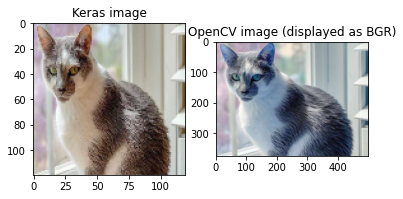

In [19]:
# Range before preprocessing
print('np.min(img_data) :',np.min(img_data))
print('np.max(img_data) :',np.max(img_data))

# Range after preprocessing
print('np.min(img_preprocessed) :',np.min(img_preprocessed))
print('np.max(img_preprocessed) :',np.max(img_preprocessed))

# Shapes
print('img_preprocessed.shape :',img_preprocessed.shape)
print('mobilenet_features.shape :',mobilenet_features.shape)
print('img_preprocessed.flatten().shape :',img_preprocessed.flatten().shape)
print('mobilenet_features.flatten().shape :',mobilenet_features.flatten().shape)

# RGB or BGR?
import cv2
import matplotlib.pyplot as plt
img_opencv = cv2.imread(str(img_path))
plt.subplot(121); plt.imshow(img_data.squeeze()/255); plt.title('Keras image')
plt.subplot(122); plt.imshow(img_opencv); plt.title('OpenCV image (displayed as BGR)')


###Extra - exploring the model further
We can explore the model even further. Let's look at the convolution layers:

In [20]:
for i, layer in enumerate(conv_base.layers):
  
  # check for convolutional layer
  layer_type = layer.__class__.__name__
  
  if 'Conv' not in layer_type:
    continue
  
  # get filter weights
  layer_name = layer.name
  input_shape = layer.input_shape
  output_shape = layer.output.shape
  filter_shape = layer.get_weights()[0].shape
  
  print(f"Layer {i} has name {layer_name}, input shape {input_shape}, filter shape {filter_shape}, and output shape {output_shape}")

Layer 2 has name conv1, input shape (None, 121, 121, 3), filter shape (3, 3, 3, 32), and output shape (None, 60, 60, 32)
Layer 5 has name conv_dw_1, input shape (None, 60, 60, 32), filter shape (3, 3, 32, 1), and output shape (None, 60, 60, 32)
Layer 8 has name conv_pw_1, input shape (None, 60, 60, 32), filter shape (1, 1, 32, 64), and output shape (None, 60, 60, 64)
Layer 12 has name conv_dw_2, input shape (None, 61, 61, 64), filter shape (3, 3, 64, 1), and output shape (None, 30, 30, 64)
Layer 15 has name conv_pw_2, input shape (None, 30, 30, 64), filter shape (1, 1, 64, 128), and output shape (None, 30, 30, 128)
Layer 18 has name conv_dw_3, input shape (None, 30, 30, 128), filter shape (3, 3, 128, 1), and output shape (None, 30, 30, 128)
Layer 21 has name conv_pw_3, input shape (None, 30, 30, 128), filter shape (1, 1, 128, 128), and output shape (None, 30, 30, 128)
Layer 25 has name conv_dw_4, input shape (None, 31, 31, 128), filter shape (3, 3, 128, 1), and output shape (None, 15, 

Display some filters from layer 2:

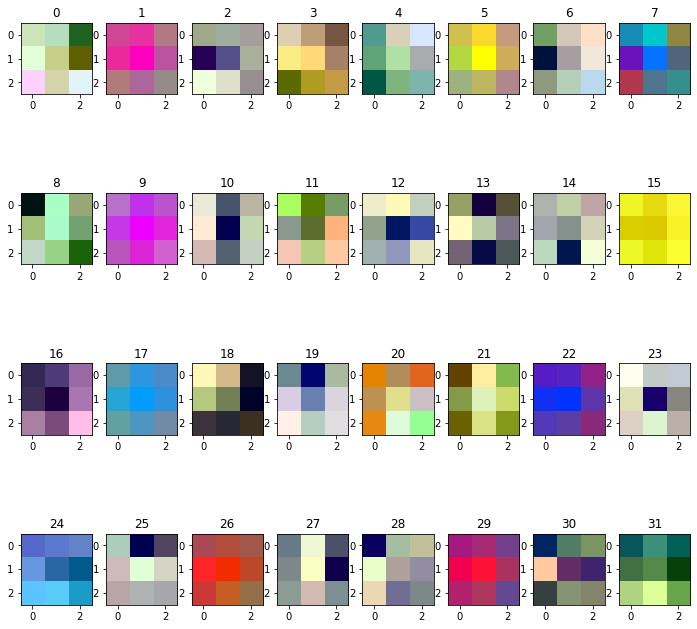

In [21]:
import matplotlib.pyplot as plt
layer = conv_base.layers[2] # Pick layer 2 from the list above
filters = layer.get_weights()
plt.figure(figsize=(12,12))
for i in range(32):
  f = filters[0][:,:,:,i]
  
  # Normalize to range 0 ... 1
  f -= f.min()
  f /= f.max()
  
  plt.subplot(4,8,i+1)
  plt.imshow(f)
  plt.title(str(i))

And display the resulting outputs (called **feature maps**):

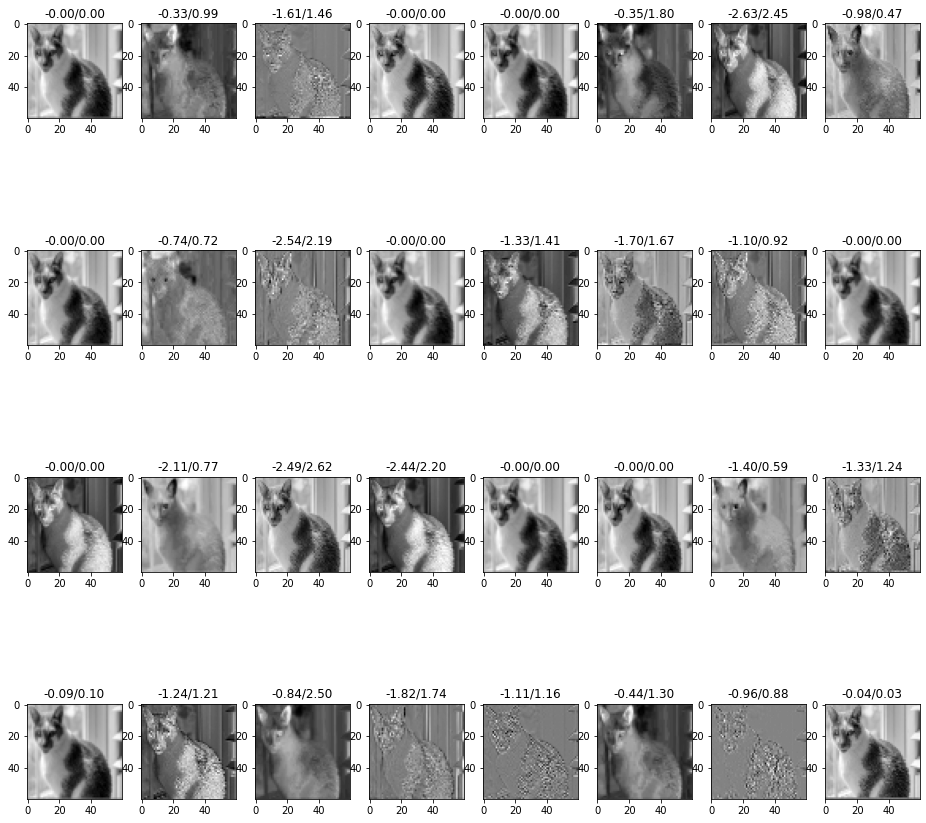

In [22]:
from keras import Model
dummy_model = Model(inputs=conv_base.input, outputs=conv_base.get_layer('conv1').output) # See conv_base.summary() for complete list of layer names
out = dummy_model.predict(img_preprocessed)
out = np.reshape(out,(60,60,32))

plt.figure(figsize=(16,16))
for i in range(32):
  f = out[:,:,i]
  plt.subplot(4,8,i+1)
  plt.imshow(f,cmap='gray')
  plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

Layers you could also inspect (layer names are written in **bold**):

**conv1_pad** (ZeroPadding2D)    (None, 121, 121, 3)       0         
_________________________________________________________________
**conv1** (Conv2D)               (None, 60, 60, 32)        864       
_________________________________________________________________
**conv1_bn** (BatchNormalization (None, 60, 60, 32)        128       
_________________________________________________________________
**conv1_relu** (ReLU)            (None, 60, 60, 32)        0         
_________________________________________________________________
**conv_dw_1** (DepthwiseConv2D)  (None, 60, 60, 32)        288       
_________________________________________________________________
**conv_dw_1_bn** (BatchNormaliza (None, 60, 60, 32)        128       
_________________________________________________________________
**conv_dw_1_relu** (ReLU)        (None, 60, 60, 32)        0         
_________________________________________________________________
**conv_pw_1** (Conv2D)           (None, 60, 60, 64)        2048      
_________________________________________________________________
**conv_pw_1_bn** (BatchNormaliza (None, 60, 60, 64)        256       
_________________________________________________________________
**conv_pw_1_relu**(ReLU)        (None, 60, 60, 64)        0         
_________________________________________________________________
**conv_pad_2** (ZeroPadding2D)   (None, 61, 61, 64)        0         

You may find more knowledge about the layer types here:
- https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
- https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
- https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

##Task 6: How to use the image generator 
Loading and preprocessing images is such a common thing in deep learning that frameworks like Keras provide predefined tools for us that we can use. 
In this task we will look at Keras' image data generator: https://keras.io/preprocessing/image/#imagedatagenerator-class. Simply put, the image generator is a tool that makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 32 images:


In [35]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True)

Found 1011 images belonging to 3 classes.


**Note:** Check that the classes assigned by the generator are consistent with your class assignment:

In [36]:
print(generator.class_indices)
print(classes)

{'cat': 0, 'dog': 1, 'horse': 2}
['cat', 'dog', 'horse']


In [34]:
!ls -A 'gdrive/My Drive/data'

cat  cat.csv  dog  dog.csv  horse  horse.csv


Here is one way to generate a new batch:

In [37]:
inputs, labels = generator.next()

###Questions 6.1
1. What is variable "inputs"?
2. What is variable "labels"?
3. How does the image generator know where the images are stored?
4. How does the image generator know the class of each image?
5. What does shuffle mean?

###Answers
See code below answers.
1. The shape of inputs is 32x120x120x3. So this is a mini-batch of 32 images of size 120x120x3.
2. Variable labels has size 32x3. Each row is a one-hot encoded label: It is a vector of zeros everwhere, except at the entry corresponding to the crrect class index.
3. First argument to the function flow_from_directory is a path to a directory containing the images. There should be a sub directory for each class.
4. By reading the name of the sub directory :-)
5. If shuffle is set to False, all images will be read in alpha-numeric order. This is usually bad, because it means that we will first load all cat images, then all dog images, etc. If we train on mini-batches, this implies that the first many batches will only contain cats, so if we are training a neural network, it will essentially learn nothing useful. We should have images from as many classes as possible in each batch.

In [ ]:
# Shapes
print('inputs.shape :',inputs.shape)
print('labels.shape :',labels.shape)
print('labels :',labels) # One-hot encoding

inputs.shape : (32, 120, 120, 3)
labels.shape : (32, 3)
labels : [[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


As you learned in lecture 2 it is always a good idea to split the data into a training set and a validation set. Again, this is such a common thing in deep learning that the image generator can do it for us:

In [38]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 810 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


###Questions 6.2
1. How does each of the two generators know if it should produce training or validation images?
2. What is the validation percentage in this example?

###Answers
1. Training or validation is determined by argument "subset", which can be either 'training' or validation'.
2. The validation percentage (i.e., the percentage of images that we keep aside for validation) is determined by argument "validation_split". It is 20% in this example, which is a commonly used value in practise.

Now, you can in principle create a complete training set and a validation set of images:

In [39]:
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features = np.zeros(shape=(sample_count, 120*120*3))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        features_batch = np.reshape(inputs_batch,(32,120*120*3))
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

num_train_batches = 20
num_validation_batches = 4
train_features_raw, train_labels_raw = extract_features(train_generator, 32, num_train_batches)
validation_features_raw, validation_labels_raw = extract_features(validation_generator, 32, num_validation_batches)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3


Show the first 32 images of the validation data set (verify that the labels are correct):

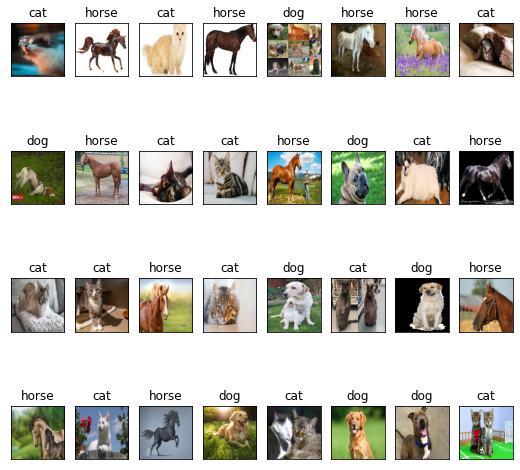

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
for i in range(32):
  img = (np.reshape(validation_features_raw[i,:],(120,120,3))+1)/2
  plt.subplot(4,8,i+1)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.title(classes[int(validation_labels_raw[i])])

###Questions 6.3
The image data has now been vectorized.
1. What is the shape of ```train_features_raw``` and ```train_labels_raw```?
2. What is the shape of ```validation_features_raw``` and ```validation_labels_raw```?
3. Notice the values of ```num_train_batches``` and ```num_validation_batches```. What are the implications of this?

###Answers
The point of these two questions is to realize we have now vectorized the images and replaced the one-hot encoding with just a class index.
1. The shape of ```train_features_raw``` is 640 x 43200. This means that we have 640 observations (images) in our training set, each represented as a 43200 dimensional vector. ```train_labels_raw``` is just a vector of length 640. The i'th entry is an index corresponding to the correct class index of the i'th observation.
2. Same as before, except there are only 120 observations in the validation set.
3. Assume that your training set contains ```N``` images, and that each batch contains 32 images. The generator is set to load ```num_train_batches``` batches, meaning that it loads a total of ```M = num_train_batches X 32``` images. If ```M < N``` then not all of your training images are loaded and used for training. This is suboptimal, becuase you are not making full use of the available training data. On the other hand, if ```M > N``` then some training images will loaded at least twice, because the generator just keeps outputting batches of randomly selected images from your training set. The implication is that you risk overfitting your model, because some training examples are ssen more often than others during training.


In [ ]:
print('train_features_raw.shape :',train_features_raw.shape)
print('train_labels_raw.shape :',train_labels_raw.shape)
print('validation_features_raw.shape :',validation_features_raw.shape)
print('validation_labels_raw.shape :',validation_labels_raw.shape)

train_features_raw.shape : (640, 43200)
train_labels_raw.shape : (640,)
validation_features_raw.shape : (128, 43200)
validation_labels_raw.shape : (128,)


##Task 7: Classify images using K-NN and raw pixels
The features that we have just calculated correspond to the raw pixel values. Now, your task is to train a K-NN classifier on the training set, and evaluate the performace on the validation set (i.e., what is the accuracy on the validation set?)

The training set consists of variables

```
train_features_raw, train_labels_raw
```

and the validation set consists of variables

```
validation_features_raw, validation_labels_raw
```


You are on your own here. You don't have to implement K-NN yourself. I suggest you use [scikit-learn](https://scikit-learn.org). Personally, I found this tutorial quite useful: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

###Solution

In [41]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
from sklearn import neighbors

# Train on training set with k = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree').fit(train_features_raw,train_labels_raw)

# Predict on validation set
pred = clf.predict(validation_features_raw)

# Accuracy
num_correct = len(np.where(pred==validation_labels_raw)[0])
num_total = len(validation_labels_raw)
accuracy = num_correct / num_total
print(accuracy)

0.4921875


So significantly better than guessing at random, but not that impressive.

##Task 8: Classify images using K-NN and neural net features
Now, repeat the same task, but this time using the features calculated using the pre-trained neural network, rather than the raw pixel values.

(*NOTE: Running this code block sometimes courses an error, when I run it. I haven't found a way to fix it yet. If it happens to you, just keep running the code block until it doesn't fail...*)

In [54]:
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features = np.zeros(shape=(sample_count, 3*3*1024))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        # This is where we apply the CNN encoder to "convert" the image into a feature vector
        features_batch = conv_base.predict(inputs_batch)
        features_batch = np.reshape(features_batch,(32,3*3*1024))
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

num_train_batches = 20
num_validation_batches = 4
train_features, train_labels = extract_features(train_generator, 32, num_train_batches)
validation_features, validation_labels = extract_features(validation_generator, 32, num_validation_batches)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3


###Solution

In [46]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
from sklearn import neighbors

# Train on training set with k = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree').fit(train_features,train_labels)

# Predict on validation set
pred = clf.predict(validation_features)

# Accuracy
num_correct = len(np.where(pred==validation_labels)[0])
num_total = len(validation_labels)
accuracy = num_correct / num_total
print(accuracy)

0.8671875


Much better! :-)

If everything went as planned, you should be able to conclude that the accuracy of the K-NN classifier is significantly higher when using the neural networks features compared to when using the raw pixel values as features. This is becuase the MobileNet has already been pre-trained, i.e., it has learned features that are useful for classifying 1000 different object categories. In almost any scenario you can think of, MobileNet's feature representation will be better than using the raw pixels.

##Task 9: K-means clustering
So what we have learned so far is that images of the same class tend to group closer together when using MobileNet's feature representation, but not so much when using the raw intensities. This confirms that using the raw pixels as features is in general a bad idea.

The reason that MobileNet's feature representation works better is because the network has learned to map images onto a manifold. A manifold is kind of like a low-dimensional surface that exists in a high-dimensional space. For instance if images of faces were to be mapped into a 4D manifold, the first axis on the manifold could represent gender, and the others could represent age, view angle, and eye color. You can read more about manifold learning in chapter 5.11.3 of [the book](https://github.com/janishar/mit-deep-learning-book-pdf).

The underlying hypothesis of using K-NN to classifiy images based on the features computed by MobileNet is that *objects that are similar will map to the approximate same location on some manifold.* Here we will perform K-means clustering and verify that this is in fact the case. For the record, recall that the K-means method is an *undersupervised learning method*, so it doesn't know anything about the class labels.

Your task is to perform K-means clustering twice on your dataset: first using the raw intensity features (```train_features_raw```), then using the MobileNet features (```train_features```). Use as many clusters as you have classes.

Again, you don't have to implement K-menas clsutering from scratch. You can use scikit-learn. I used this tutorial for inspiration: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

For each cluster, print the class labels of all images in that cluster. Explain what you observe and compare between MobileNet features and raw pixel intensities.

###Solution: Raw pixels
Look at the three arrays printed below. The labels look pretty random. In other words, the clusters found by K-means using raw pixel values are not related to the object categories.

In [47]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(train_features_raw)

pred = kmeans.predict(train_features_raw)

for c in range(3):
  ix = np.where(pred==c)[0]
  print(train_labels_raw[ix])

[0. 2. 1. 2. ... 0. 0. 0. 0.]
[0. 2. 2. 0. ... 1. 1. 1. 1.]
[1. 2. 2. 2. ... 2. 1. 1. 2.]


###Solution: Network features
Look at the three arrays printed below. The labels correspond pretty much to the clusters found by K-means, which (again) knows nothin about the labels.

Cool, right? :-)

In [48]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(train_features)

pred = kmeans.predict(train_features)

for c in range(3):
  ix = np.where(pred==c)[0]
  print(train_labels[ix])

[2. 1. 2. 2. ... 2. 2. 1. 2.]
[2. 2. 1. 0. ... 2. 0. 1. 1.]
[0. 0. 0. 0. ... 0. 1. 0. 0.]


###Extra : Visualising high-dimensional datasets using PCA and t-SNE in Python
See here: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Simply speaking, t-SNE is a dimensionality reduction technique that maps N-dimensionalal data to, say, 2-D, where points that are close in N-dimensional space are close in the 2D space.

t-SNE allows us to visually verify that when using the raw pixels as features, the data points do not form clusters corresponding to the classes:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(640, 43200) (640,)
Size of the dataframe: (640, 43202)
Explained variation per principal component: [0.298724 0.07762  0.047664]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 640 samples in 1.718s...
[t-SNE] Computed neighbors for 640 samples in 33.513s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 35.039109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.905365
[t-SNE] KL divergence after 300 iterations: 1.742628
t-SNE done! Time elapsed: 36.229711294174194 seconds


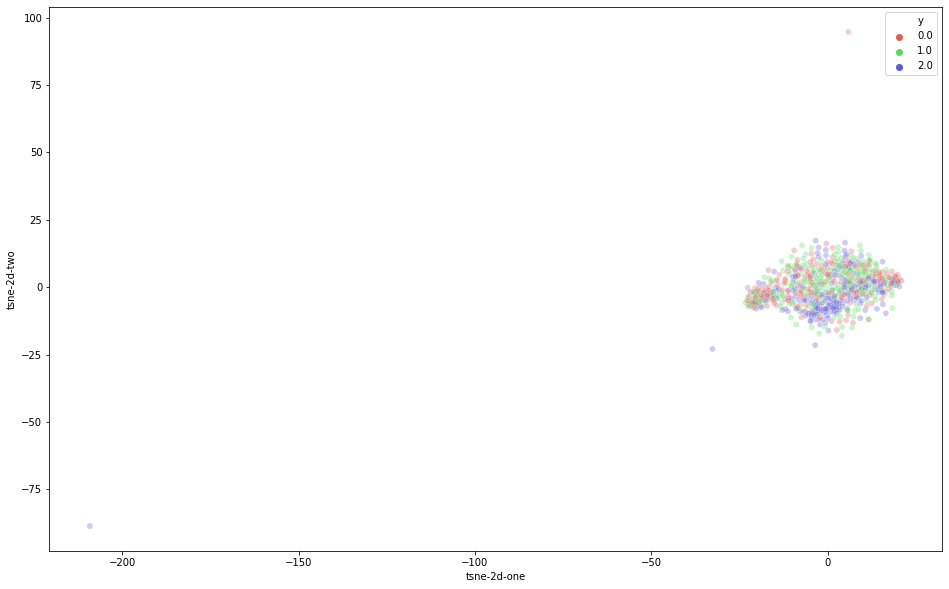

In [49]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

X = train_features_raw
y = train_labels_raw
print(X.shape, y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

rndperm = np.random.permutation(df.shape[0])

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(classes)),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Figure above: Raw pixels mapped to 2D using t-SNE. The data points do not form clusters corresponding to the classes (red, green, blue dots).

Now, let's repeat the t-SNE analysis, but this time using the CNN features is input:

(640, 9216) (640,)
Size of the dataframe: (640, 9218)
Explained variation per principal component: [0.055454 0.034228 0.020829]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.404s...
[t-SNE] Computed neighbors for 640 samples in 7.154s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 55.289795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.376846
[t-SNE] KL divergence after 300 iterations: 1.536005
t-SNE done! Time elapsed: 8.718200206756592 seconds


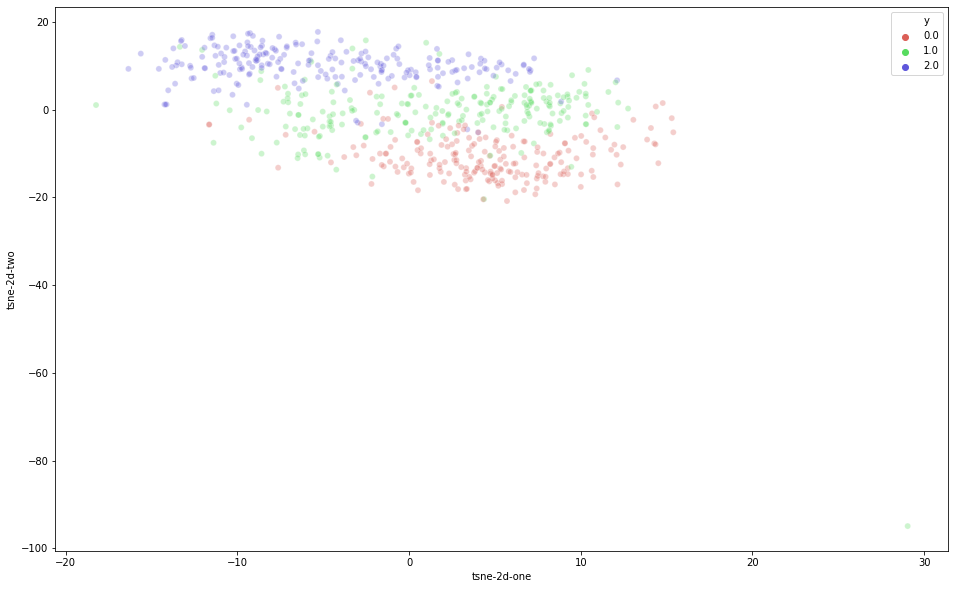

In [50]:
# Same as above, but using CNN feature representation
X = train_features
y = train_labels
print(X.shape, y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(classes)),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Figure above: Now, the data points form clusters corresponding to the classes.

##Task 10: Image retrieval
You can use the features of MobileNet to implement an image search engine. This is also called image retrieval.

To make this work you need to create a new database, where each entry contains an image **and** its feature vector (as computed by MobileNet).

The search engine work like this:

1. Given an input image, pre-process it and feed it through MobileNet to calculate the feature vector.
2. Then perform a K-NN search with K=10 against the feature vectors in the database.
3. Then return the corresponding 10 closest images (also stored in the database).

###Solution

In [56]:
# Function returns pairs of observations:
# - features_raw are the raw images
# - features_net are the network feature vectors
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features_raw = np.zeros(shape=(sample_count, 120*120*3))
    features_net = np.zeros(shape=(sample_count, 3*3*1024))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        features_batch = np.reshape(inputs_batch,(32,120*120*3))
        features_raw[i * batch_size : (i + 1) * batch_size] = features_batch
        
        features_batch = conv_base.predict(inputs_batch)
        features_batch = np.reshape(features_batch,(32,3*3*1024))
        features_net[i * batch_size : (i + 1) * batch_size] = features_batch
        
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features_raw, features_net

num_batches = 20
features_raw, features_net = extract_features(train_generator, 32, num_batches)

# Train K-NN classifier on network features (features_net) with k = 10
nbrs = neighbors.NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(features_net)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


File path: /content/gdrive/My Drive/data/horse/00000007.jpg
[204.333927 205.450563 209.05151  214.002921 215.909652 218.304862 221.421729 224.186176 225.958458 226.045193]
[350 164 594 283 256 252 242  46  34   4]


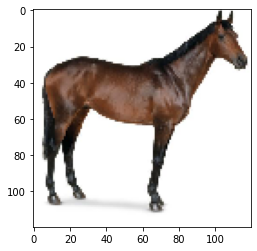

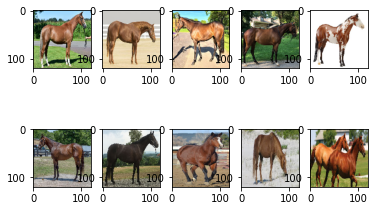

In [64]:
# Pick test image
filelist = [x for x in (p/classes[2]).iterdir() if x.is_file()]
img_path = filelist[0]
print(f"File path: {img_path}")

# Load and preprocess
img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

# Feed test image through network to get feature vector
X = conv_base.predict(img_data)
X = np.reshape(X,(1,3*3*1024)) # Vectorize

# Get indicies of 10 nearest neighbours (+ distances)
distances, indices = nbrs.kneighbors(X)

print(distances[0])
print(indices[0])

# Display nearest neighbours
plt.figure()
plt.imshow((img_data[0,:,:,:]+1)/2) # Scale image to rage 0 to 1
plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  im = (np.reshape(features_raw[indices[0][i],:],(120,120,3)) + 1) / 2
  plt.imshow(im)

So these are the ten closest images in the neural networks feature space. Visually they are not necessarily similar, but semantically they should be similar (i.e., if the input image displays a cat, most of the 10 nearest images should also display cats).

##Task 11: Transfer learning


Putting your own K-NN classifier on top of a pre-trained CNN is not really optimal. Why? Because, while the features of the convolutional base are better than using raw pixel values, they are not guaranteed to 100% optimal for your specific task. So, a better solution is to attach a second neural network on top of the convolutional base, and train both the classifier *and* the convolutional base at the same time. This is called **transfer learning**. The extra neural network that put on top of our encoder is often referred to as a "decoder".

Recall that CNNs like AlexNet and MobileNet have been trained on ImageNet, which contains 1000 classes. If you download Keras' pre-trained models *including the top layers* (i.e., the decoder), the top layers are in fact the classifier that we want to replace. Let's verify this:

In [65]:
mobilenet_full = MobileNet(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))
mobilenet_full.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

###Questions 11.1
Inspect the printout above.
1.  Can you identify the convolutional base of this network? (Compare to the ```conv_base``` model we used earlier.)
2. All layers beyond the convolutional base represent the classifier (or decoder). How many classes are there?
3. So what is the size of the output of the model?
4. Can you guess how we should interpret the output of model?
5. The input size must be 224 by 224 pixels (you can verify for yourself). Why do you think that is? 

###Answers:
1. The convolutional base consists of all layers up and until conv_pw_13_relu, which produces an output of size 7x7x1024. This is then converted into a 1024-dimensional vector using global average pooling. This suggests that the network is just averaging over the entire 7x7 grid.
2. There are 1000 classes (because there are 1000 classes in the ImageNet database)
3. So the output of the network is a 1000-dimensional vector - one entry per class.
4. The i'th entry in the output vector is *the probability* that the input image belongs to the ith class, *as predicted by the network*.
5. A neural network is essentially a bunch of matrix-vector multiplications (plus a few more operations...). If the sizes of the matrices and vectors do not match, the math doesn't work. This is the most likely explanation, but in fact changing the input image size shouldn't cause problems here because global_average_pooling2d_1 effectively removes the 7x7 grid, which is where we could get into trouble with matrix/vector size mismatches... I guess changing the input size just doesn't work in practise, in the sense that the math works, but the network doesn't perform that well (i.e., accuracy is low).

So, how do we modify and re-train MobileNet to work on your own data? First of all, we don't want to train CNNs from scratch, since this could take days. Secondly, we need to modify the network architecture to output, say, three class labels instead of 1000.

The main hypothesis underlying transfer learning is that the network weights learned in the convolutional layers (i.e., the *encoder*) are generic and need little or no fine-tuning to work on other data sets or tasks. So in practice, we just need to replace and re-train the last layers (i.e., the *decoder*) of a pre-trained network.

So let's take our convolutional base (encoder) and put a simple neural network classifier (decoder) on top of it. Your task is to figure out what the value of variable N should be.

###Solution

In [66]:
N = len(classes) # Number of classes

In [67]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
x = conv_base.output # 3x3x1024
x = GlobalAveragePooling2D()(x) # 1024
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Note that the weights of the new dense layers are initialized with random values.

###Questions 11.2
1. What should N be in the above code block?
2. Re-run the code block with the correct N.
3. What does GlobalAveragePooling2D do?

Hint: You can print all layers and print properties like name, type and input shape:

###Answers:
1. N is the number of classes. The network outputs a vector with one entry per class, corresponding to the class probability.
2. Done
3. global_average_pooling2d_1 gets rid of the 3x3 grid that is produced by the last layer of the convolutional base. So the 3x3x1024 array created by that layer is converted into a 1024 dimensional vector by averaging over grid cells. Why is this necessary? Because the next layer is a dense layer, which is a matrix-vector multiplication that expects a 1024-dimensional input vector.

In [68]:
for i,layer in enumerate(model.layers):
  layer_name = layer.name
  layer_type = layer.__class__.__name__
  input_shape = layer.input_shape
  print(f"Layer {i} has name {layer_name} and type {layer_type}, and its input shape is {input_shape}")
  
# Or use the summary funtion:
# model.summary()

Layer 0 has name input_1 and type InputLayer, and its input shape is [(None, 120, 120, 3)]
Layer 1 has name conv1_pad and type ZeroPadding2D, and its input shape is (None, 120, 120, 3)
Layer 2 has name conv1 and type Conv2D, and its input shape is (None, 121, 121, 3)
Layer 3 has name conv1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 32)
Layer 4 has name conv1_relu and type ReLU, and its input shape is (None, 60, 60, 32)
Layer 5 has name conv_dw_1 and type DepthwiseConv2D, and its input shape is (None, 60, 60, 32)
Layer 6 has name conv_dw_1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 32)
Layer 7 has name conv_dw_1_relu and type ReLU, and its input shape is (None, 60, 60, 32)
Layer 8 has name conv_pw_1 and type Conv2D, and its input shape is (None, 60, 60, 32)
Layer 9 has name conv_pw_1_bn and type BatchNormalization, and its input shape is (None, 60, 60, 64)
Layer 10 has name conv_pw_1_relu and type ReLU, and its input shape is (None, 

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [69]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 90
Number of pretrained base layers is 87


We are now ready to start training the model using
- Adam optimizer
- loss function will be categorical cross entropy
- evaluation metric will be accuracy


In [70]:
from keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
25/25 [==============================] - 4s 157ms/step - loss: 0.6524 - accuracy: 0.7712 - val_loss: 0.2154 - val_accuracy: 0.9271
Epoch 2/10
25/25 [==============================] - 3s 136ms/step - loss: 0.1384 - accuracy: 0.9512 - val_loss: 0.2440 - val_accuracy: 0.9062
Epoch 3/10
25/25 [==============================] - 3s 133ms/step - loss: 0.0629 - accuracy: 0.9807 - val_loss: 0.2019 - val_accuracy: 0.9167
Epoch 4/10
25/25 [==============================] - 3s 131ms/step - loss: 0.0362 - accuracy: 0.9949 - val_loss: 0.1873 - val_accuracy: 0.9271
Epoch 5/10
25/25 [==============================] - 3s 133ms/step - loss: 0.0280 - accuracy: 0.9974 - val_loss: 0.1908 - val_accuracy: 0.9271
Epoch 6/10
25/25 [==============================] - 3s 133ms/step - loss: 0.0226 - accuracy: 0.9974 - val_loss: 0.1854 - val_accuracy: 0.9323
Epoch 7/10
25/25 [==============================] - 3s 132ms/step - loss

###Questions 11.3
Look at the outputs of the training.

1. What is the difference between 'loss' and 'val_loss'?
2. What is the difference between 'accuracy' and 'val_accuracy'?
3. Do they behave the same, or do they behave differently? Try to explain what you see.

We can plot the outpus like this:

###Answers:
1. The 'loss' is the networks prediction error on the training set. This is essentially the metric that we are trying to minimize during training. If everything is set up correctly (and by that I mean hyperparameters such as learning rate), the training loss should decrease over time. It can fluctuate, however, and that is because it is not evaluated on the entire training data set, but rather on small mini-batches. This can course some random variation. The 'val_loss' is the loss on the validatin data set, i.e., images not seen during training. This should ideally also decrease over time, but it will almost never be as low as the training loss? *The degree to which the validation loss decreases says something about how well the model generalises to unseen data*.
2. This is the evaluation metric - it is not used for optimization/training. It only serves as a human interpretable measure of of how well the model performs on the training set and the validation set. Again, we want a high accuracy on the validation set (=unseen data).
3. The training loss always decreases, and training accuracy always increases (if things are set up correctly). The validation loss/accuracy follow the same trend to begin with, but at some point we should expect them to stagnate. **CAUTION**: If the validation loss starts to increase (and accuracy drops), then it is a strong indication that your model has started **overfitting**. What does that mean? It simply means that the model has started remembering the training data set instead of learning useful features that generalize beyond the training data set. Think of the example from lecture 2 with the dog Loui. We don't want our model to remember images Loui; we want our model to learn which features distinguish the Loui-the-beaggle from other beaggles.

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


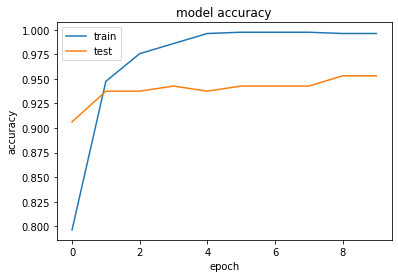

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

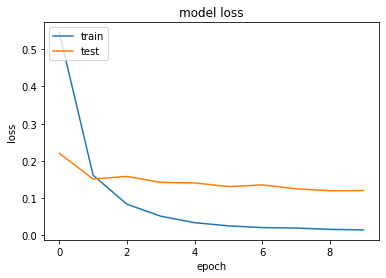

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Ideas for further work
1. In the above example we have not optimized the pre-trained weights of the convolutional base (i.e., the encoder). To improve performance further you could enable training in all layers (including the convolutoinal base) and re-train the network. This is called *fine-tuning*.
2. Another way to improve model performance is by *data augmentation*. Have a look at the documentation for the [image generator class](https://keras.io/preprocessing/image/) and see what kind of augmentation is possible. Why do you think data augmentation helps improve the performance of your model?
3. Try repeating the above experiments on the MNIST dataset. Take a look here: https://keras.io/examples/mnist_cnn/

###Hints:
1. To enable training of all layers:

In [ ]:
for layer in model.layers[:num_base_layers]:
    layer.trainable=True

2. See examples of data augmentation here:

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

File path: /content/gdrive/My Drive/data/cat/00000003.jpg
File path: /content/gdrive/My Drive/data/cat/00000003.jpg


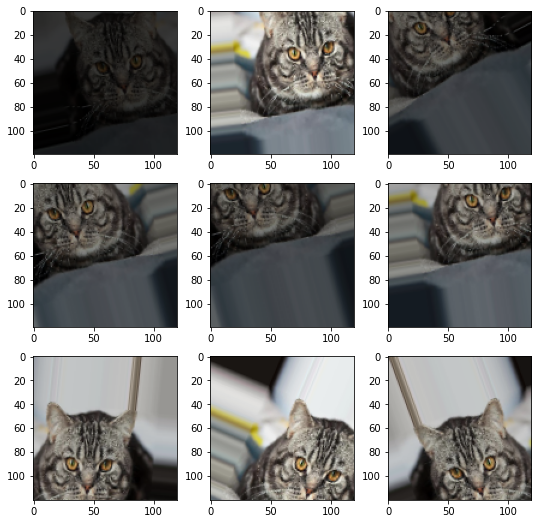

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-20,20],
                             height_shift_range=0.5,
                             horizontal_flip=True,
                             rotation_range=30,
                             brightness_range=[0.2,1.0])
# prepare iterator
it = datagen.flow(img_data, batch_size=1)

plt.figure(figsize=(9,9))
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	img = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(img)
# show the figure
plt.show()

3. See below how to load MNIST. Your main challenge is going to be that that input images are 28x28x1, and MobileNt accepts only images that are 32x32x3 or larger. So what to do?

In [ ]:
import keras
from keras.datasets import mnist

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# Convert to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# This will produce an error...
model.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

##Optional task: Deploying the model
Here is how to deploy the model and integrate with OpenCV.

File path: /content/gdrive/My Drive/data/cat/00000003.jpg


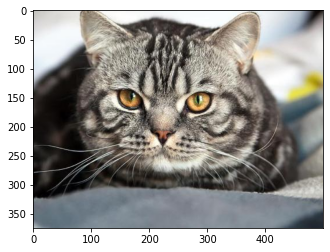

In [ ]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Load and display with OpenCV (rememebr to convert to RGB!!!)
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
plt.imshow(img)

Now, make sure that the image shape and the pixel intensity range is as expected by the network:

In [ ]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape)

(1, 120, 120, 3)


Run the image through the network:

In [ ]:
pred = model.predict(img)[0]
ind = (-pred).argsort()[:3]
latex = [(classes[x],pred[x]) for x in ind]
print(latex)

[('cat', 0.9994869), ('dog', 0.00049744133), ('horse', 1.5580054e-05)]


In [ ]:
print(pred)

[9.994869e-01 4.974413e-04 1.558005e-05]


##Optional task: Exporting to TensorFlow JS and hosting a web service on GitHub
If you want to, you can deploy your model and make a nice web service like this one:
https://klaverhenrik.github.io/transferlearning/

To do that, first export your model to [TensorFlow JS](https://www.tensorflow.org/js) and download all the necessary files as a zip file:

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

/bin/bash: tensorflowjs_converter: command not found


In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [ ]:
with open('my_classes.js','w') as file_handler:
  file_handler.write("export const IMAGENET_CLASSES = {\n")
  for ix, item in enumerate(classes):
    file_handler.write("  " + str(ix) + ": \'" + item + "\'")
    if ix < len(classes)-1:
      file_handler.write(",")
    file_handler.write("\n")
  file_handler.write("};")

In [ ]:
!pip install tensorflowjs 

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 137.3MB 22kB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 256kB 69.5MB/s 
     |████████████████████████████████| 921kB 59.8MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=9909d74e0ac796d4d99e9725f984dd160580d43d3e80b63c254f625d535ec1b6
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 0

In [ ]:
model.save('keras.h5')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists


In [ ]:
!cp class_names.txt model/class_names.txt
!cp my_classes.js model/my_classes.js

In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 95%)
  adding: model/group1-shard4of5.bin (deflated 8%)
  adding: model/my_classes.js (deflated 7%)
  adding: model/group1-shard3of5.bin (deflated 7%)
  adding: model/group1-shard5of5.bin (deflated 8%)
  adding: model/group1-shard2of5.bin (deflated 7%)
  adding: model/group1-shard1of5.bin (deflated 7%)
  adding: model/class_names.txt (stored 0%)


In [ ]:
from google.colab import files
files.download('model.zip')

Now that you have converted you model to TensorFlow JS and downloaded, you can clone [this git repo](https://github.com/klaverhenrik/klaverhenrik.github.io/tree/master/transferlearning) and copy the model files into your own copy of the repo.

The webpage can be hosted on GitHub using [GitHub Pages](https://pages.github.com/).